In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

In [2]:
input_a = Input(shape=[1],name = 'wide')
input_b = Input(shape= [1], name = 'deep')

hidden_1 = tf.keras.layers.Dense(50 , activation='relu')(input_b)
hidden_2 = tf.keras.layers.Dense(50, activation='relu')(hidden_1)

concat = concatenate([input_a , hidden_2])
out_put = tf.keras.layers.Dense(1 , name = 'output')(concat)

# define another output for the deep path
aux_output = Dense(1,name="aux_Output")(hidden_2)

model = Model(inputs = [input_a,input_b] ,outputs =[out_put,aux_output])

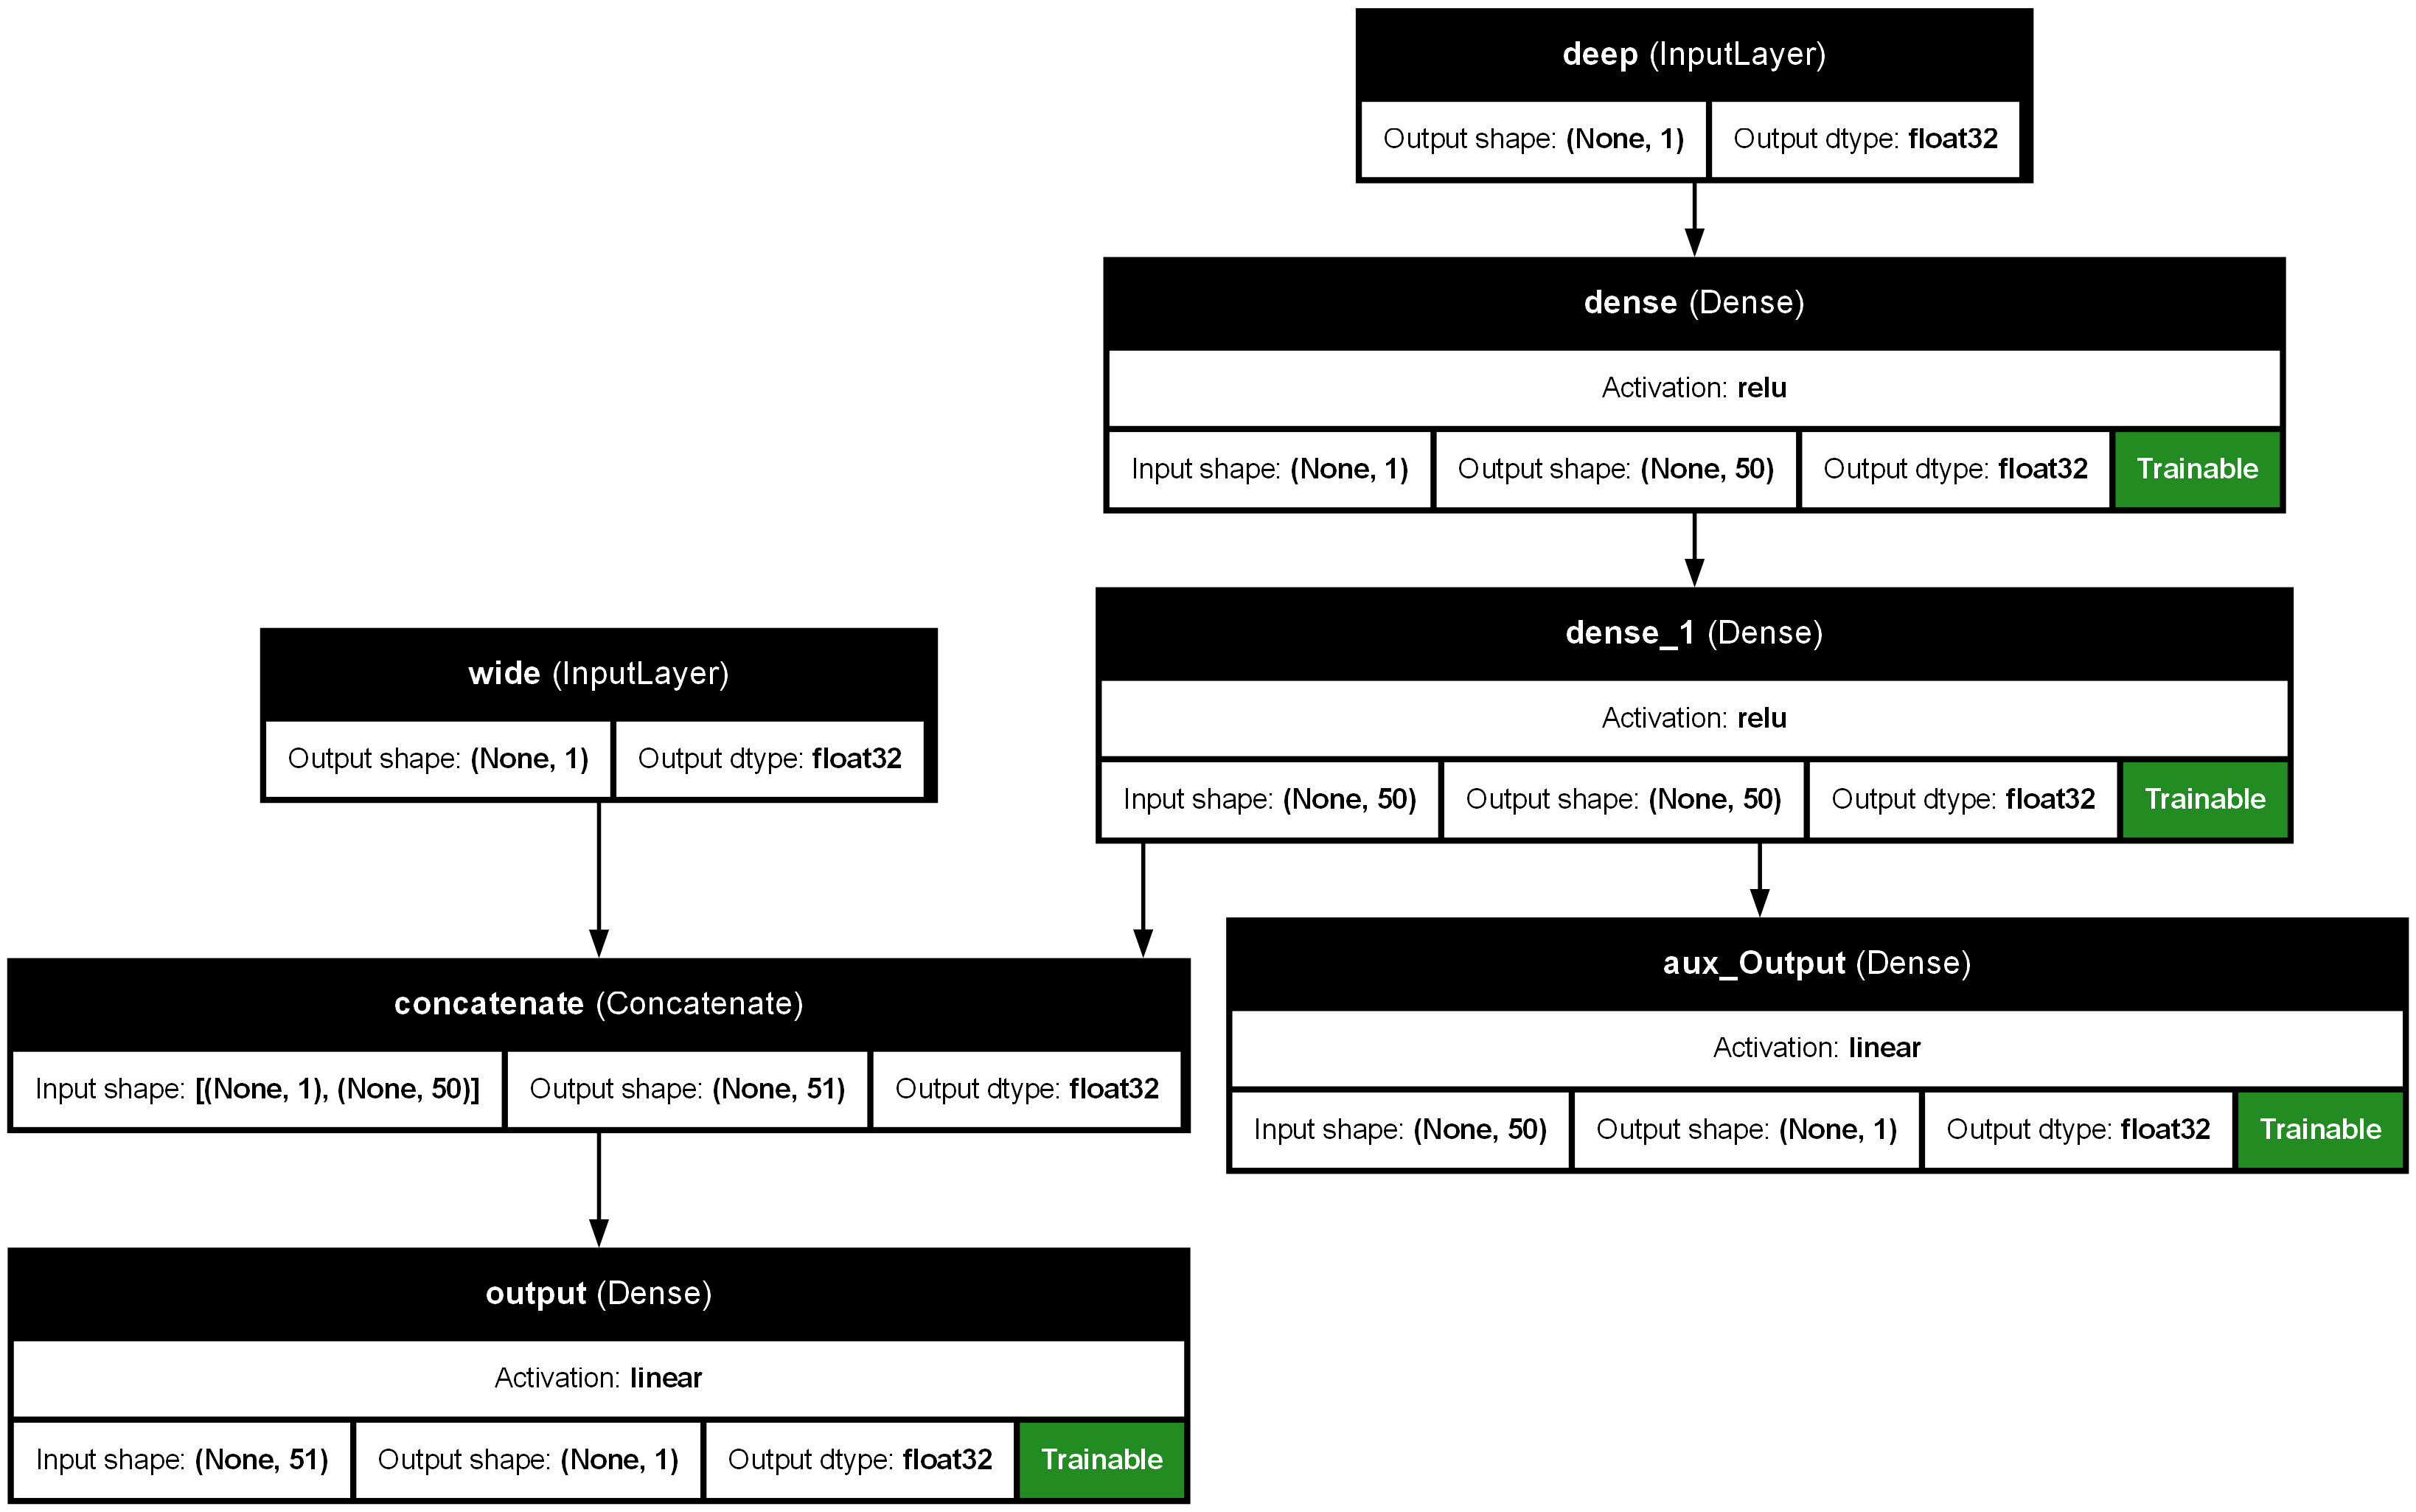

In [3]:
# visualize the architecture
plot_model(model, to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,)

In [4]:
class wide_deep (tf.keras.Model):
    def __init__(self, unit = 32, activation ='relu' ,**kwargs):
        super(wide_deep,self).__init__(**kwargs)
        self.hidden_1 = tf.keras.layers.Dense(units=unit,activation=activation)
        self.hidden_2 = tf.keras.layers.Dense(units=unit,activation=activation)
        self.main_output = tf.keras.layers.Dense(1,activation='linear')
        self.aux_output = tf.keras.layers.Dense(1,activation='linear')

    def call(self,inputs):
        input_a, input_b = inputs
        hidden_1 = self.hidden_1(input_b)
        hidden_2 = self.hidden_2(hidden_1)
        concat = tf.keras.layers.concatenate([hidden_2,input_a])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden_2)
        return main_output ,aux_output

In [5]:
model = wide_deep()

In [6]:
model.layers

[<Dense name=dense_2, built=False>,
 <Dense name=dense_3, built=False>,
 <Dense name=dense_4, built=False>,
 <Dense name=dense_5, built=False>]

In [7]:
model.summary()

Model: "wide_deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
x = tf.ones(shape=(2,2))
y = model(inputs = (x,x))

In [9]:
model.summary()

Model: "wide_deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (2, 32)                │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (2, 32)                │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (2, 1)                 │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (2, 1)                 │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,220 (4.77 KB)

 Trainable params: 1,220 (4.77 KB)

 Non-trainable params: 0 (0.00 B)

## mini resnet 

Because multiple layers are repeated one after another, we implement a custom layer.

To decide whether we need to create a custom layer or a custom model, we should ask ourselves: Is what I wrote supposed to use methods like .fit, .compile, .evaluate, or others? If not, then just implement it as a layer.

پیاده‌سازی یک مدل Mini-ResNet با استفاده از Model Subclassing


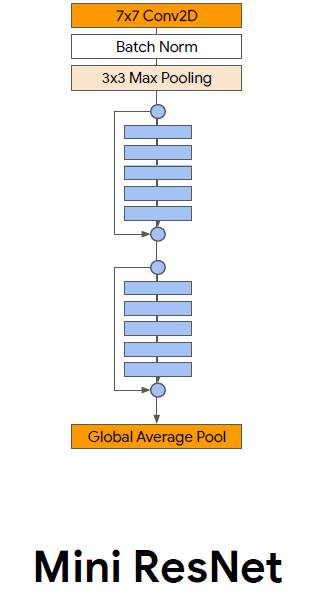

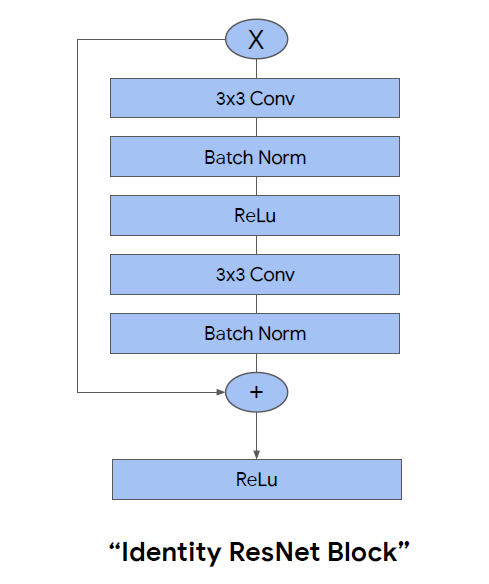

In [172]:
from keras.saving import register_keras_serializable
@register_keras_serializable()
class identity_resnet_block(tf.keras.layers.Layer):
    def __init__(self, filters_, kernels_size_, **kwargs):
        super(identity_resnet_block, self).__init__(**kwargs)
        self.filters_ = filters_
        self.kernels_size_ = kernels_size_
        self.conv1 = tf.keras.layers.Conv2D(filters=filters_, kernel_size=kernels_size_, padding='same')
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=filters_, kernel_size=kernels_size_, padding='same')
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.act(x)
        x = self.add([x, inputs])
        x = self.act(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters_": self.filters_,
            "kernels_size_": self.kernels_size_
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [174]:
identy_leyer = identity_resnet_block(filters_ =3 , kernels_size_ =3 )

In [176]:
x_test = tf.random.normal(shape = (8, 224, 224, 3))
y = identy_leyer(x_test)

Now, similar to the above structure, we create our model.

In [179]:
from keras.saving import register_keras_serializable
@register_keras_serializable()
class Resnet(tf.keras.Model):
    def __init__(self, num_class, **kwargs):
        super(Resnet, self).__init__(**kwargs)
        self.num_class = num_class
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=7, padding='same')
        self.bat1 = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.maxpol = tf.keras.layers.MaxPool2D(pool_size=3)
        self.gol = tf.keras.layers.GlobalAvgPool2D()
        self.ide1 = identity_resnet_block(64, 7)
        self.ide2 = identity_resnet_block(64, 7)
        self.class_out = tf.keras.layers.Dense(num_class, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bat1(x)
        x = self.act(x)
        x = self.maxpol(x)
        x = self.ide1(x)
        x = self.ide2(x)
        x = self.gol(x)
        return self.class_out(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_class": self.num_class
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## load data

In [182]:
data_set = tfds.load(
    name='mnist',
    split=tfds.Split.TRAIN,
    download=True,
    try_gcs=True
)

In [184]:
data_set.element_spec

{'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

## preprocecing 

In [187]:
def preprocecing (data_s):
    return tf.divide(tf.cast(data_s['image'],tf.float32),255.0), data_s['label']

In [189]:
data_set_pre = data_set.map(preprocecing).batch(32)

## fit

In [192]:
# create a ResNet instance with 10 output units for MNIST
resnet = Resnet(num_class = 10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [194]:
# train the model.
resnet.fit(data_set_pre, epochs=1)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.8113 - loss: 0.5438


## save 

save the weights

In [ ]:
import os

# If the 'checkpoints' folder does not exist, create it
os.makedirs('./checkpoints', exist_ok=True)

# Now save the weights
resnet.save_weights('./checkpoints/my_checkpoint.weights.h5')


In [198]:
print(os.listdir('./checkpoints'))


['my_checkpoint.weights.h5']


In [199]:
resnet_new = Resnet(10)

In [119]:
resnet_new.load_weights('./checkpoints/my_checkpoint.weights.h5')

In this case, the weights are quickly formed using the model we have set up.

In [122]:
x_test = tf.random.normal(shape=(8, 224, 224, 1))
y = resnet_new(x_test)

## whole model

In [228]:
import os

# ۱) پوشه را بساز
os.makedirs("saved_model", exist_ok=True)

# ۲) ذخیره با فرمت Keras-v3
resnet.save("saved_model/my_model.keras")

# یا برای سازگاری با گذشته:
resnet.save("saved_model/my_model.h5")

✅ Case 3: Saving the model in SavedModel format for use in TFLite or TFServing:

In [ ]:
resnet.export("saved_model/my_model")

In [233]:
print(os.listdir('saved_model'))

['my_model.h5', 'my_model.keras']


In this case, you don't need the model's code—just the code below is enough.

In [ ]:
reconstructed_model = tf.keras.models.load_model(
    "saved_model/my_model.h5",
    custom_objects={
        "Resnet": Resnet,
        "identity_resnet_block": identity_resnet_block
    }
)

In [ ]:
reconstructed_model.summary()